<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>CET Template Notebook</b> <br>
Contact author(s): <i>Author Name</i> <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

_In this template, text in italics are examples or instructions that should be: (a) removed if it is not applicable to the notebook; or (b) replaced with text that is appropriate for the notebook. But bold or regular text should appear pretty much as-is in all CET notebooks. For more information, see the [CET's Guidelines for Tutorial Notebooks](https://confluence.lsstcorp.org/pages/viewpage.action?pageId=168857070)._

_While developing, use the following code cell to check that the code conforms to standards, but then delete the cell and "Kernel --> Restart Kernel and Clear All Outputs" before saving and committing._

In [1]:
#%load_ext pycodestyle_magic
#%flake8_on
#import logging
#logging.getLogger("flake8").setLevel(logging.FATAL)

_The six cells below are considered the extended header of the notebook. The first four will be used, verbatim, to create the table of notebook metadata in the README.md file for the repository._

**Description:** _Very brief description of notebook._

**Skills:** _Brief list of skills to match the README.md file for the repository._

**LSST Data Products:** _List the all of the types of LSST catalogs and images used._

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

**Credit:**
_E.g., "Originally developed by" or "Based on notebooks developed by" and then people's names, including journal article or software release citations if appropriate._
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

_Provide a light narrative about this notebook, e.g., "This notebook will teach the user..."._

_Cite or link to any external information or documentation, and cross-reference to other notebooks._

### 1.1 Package Imports

_All package imports should be done in the first code cell._

_Provide explanation or external links to package documentation, where appropriate._

_E.g., Numpy is a fundamental package for scientific computing with arrays in Python (<a href="https://numpy.org">numpy.org</a>)._

_Use code cell comments to describe the packages being imported._

In [2]:
# LSST package for Butler queries
import lsst.daf.butler as dafButler

# LSST package for image display
import lsst.afw.display as afwDisplay

# Import general python packages
import numpy as np
import re
import pandas
from pandas.testing import assert_frame_equal
import uuid
import requests
import warnings
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

# Science Pipelines imports
from lsst.daf.butler import Butler, DatasetType, CollectionType
import lsst.geom as geom
import lsst.resources
import lsst.afw.image as afwImage
from lsst.afw.image import Image, ImageF
from lsst.afw.image.exposure import Exposure, ExposureF

# Plotting with MPL
import matplotlib.pyplot as plt

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query
from lsst.rsp.utils import get_access_token

# PyVO packages
import pyvo
from pyvo.dal.adhoc import DatalinkResults, SodaQuery

# Astropy
from astropy import units as u
from astropy.units import UnitsWarning
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.time import Time
from astropy.utils.data import download_file
from astropy.visualization import  ZScaleInterval, AsinhStretch
from astropy.wcs import WCS       
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import ImageNormalize
from astropy.visualization.stretch import SinhStretch, LinearStretch, SqrtStretch

# Holoviz for interactive visualization
import bokeh
from bokeh.io import output_file, output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
import holoviews as hv
from holoviews import streams, opts
from holoviews.operation.datashader import rasterize

### 1.2 Define Functions and Parameters

_If your notebook defines functions or parameters to use later or throughout, do it here in sub-section 1.2._

_It is OK to rename the subsection to be more specific to the notebook, and/or to use sub-sub-sections like "1.2.1 Define global cosmological parameter values" or "1.2.2 Define a function to make an image cutout"._

_It is OK to remove this sub-section if it is not being used._

In [3]:
# Set up some plotting defaults
params = {'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 12,
          'xtick.major.width': 2,
          'xtick.minor.width': 1,
          'xtick.major.size': 10,
          'xtick.minor.size': 4,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 2,
          'axes.linewidth': 2,
          'axes.labelweight': 2,
          'axes.titleweight': 2,
          'ytick.major.width': 2,
          'ytick.minor.width': 1,
          'ytick.major.size': 10,
          'ytick.minor.size': 4,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [6, 6],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [4]:
def plotImage(exposure: ExposureF, img_opt: dict = None):
    """Plot and image using matplotlib
   
   Parameters
    ----------
    image : `Exposure`
        the image to plot
        
    opts : ``
   
   Returns
    -------
    title : `str` (only if result is not `None`)
        Plot title from string
    """
    
    fig, ax = plt.subplots()
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')
    display.mtv(exposure.image)
    plt.show()


In [5]:
def make_image_cutout(butler, tap_service, ra, dec, cutout_size=0.01):
    """Make a cutout using the cutout tool
   
   Parameters
    ----------
    # cutout_size is in degrees
    # i think we need to add option to request calexp vs deepcoadd
   
   Returns
    -------
    
    """

    spherePoint = lsst.geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)
    registry = butler.registry
    # Find the tract and patch that contain this point
    skymap = butler.get('skyMap')
    tract = skymap.findTract(spherePoint)
    patch = tract.findPatch(spherePoint)

    # Now create a dataId from the tract, patch and filter information
    dataId = {'band':'i', 'tract':tract.tract_id, 'patch': patch.getSequentialIndex()}


    # Need the UUID of the image for the cutout service 
    datasetRef = registry.findDataset('deepCoadd_calexp', dataId)
    deepCoadd_uuid = datasetRef.id
    assert isinstance(deepCoadd_uuid, uuid.UUID)
    f"UUID for deep coadd: {deepCoadd_uuid}"

    #Get from dataID (needs to be fixed)
    t = tract.tract_id
    p = patch.getSequentialIndex()

    query = "SELECT access_format, access_url, dataproduct_subtype, lsst_patch, lsst_tract, " + \
        "lsst_band, s_ra, s_dec FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
        "AND obs_collection = 'LSST.DP02' " + \
        "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
        "AND lsst_tract = " + str(t) + " " + \
        "AND lsst_patch = " + str(p) + " " + \
        "AND lsst_band = 'i' "
    results = tap_service.search(query) # THIS IS TAP SERVICE

    #Get datalink
    dataLinkUrl = results[0].getdataurl()
    f"Datalink link service url: {dataLinkUrl}"
    auth_session = service._session
    dl_results = DatalinkResults.from_result_url(dataLinkUrl,session=auth_session)
    f"{dl_results.status}"

    sq = SodaQuery.from_resource(dl_results, dl_results.get_adhocservice_by_id("cutout-sync"), 
                                 session=auth_session)

    sq.circle = (spherePoint.getRa().asDegrees()* u.deg,
                 spherePoint.getDec().asDegrees()*u.deg, 
                 cutout_size* u.deg)

    sodaCutout = os.path.join(os.getenv('HOME'), 'DATA/soda-cutout.fits')
    with open(sodaCutout, 'bw') as f:
        f.write(sq.execute_stream().read())
    
    return sodaCutout

## 2. Section Heading

_Use numbers for sections, sub-sections, and sub-sub-sections to enable referencing, e.g., "I'm having trouble with the second code cell in Section 2.3."_

_Use section titles that actively describe what is being done, e.g., "Create a color-magnitude diagram" instead of "Plot", so that the auto-generated table of contents is easy to navigate._

### 2.1 Section Sub-heading

#### 2.1.1 Section Sub-sub-heading

In [6]:
# Set afw display backend to matplotlib
afwDisplay.setDefaultBackend('matplotlib')

# Set the maximum number of rows to display from pandas
pandas.set_option('display.max_rows', 20)

In [7]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')
registry = butler.registry
#butler = Butler(config, collections=collection)


In [8]:
service = get_tap_service()

In [9]:
# galaxy cluster:
#ra = 55.7467 
#dec = -32.2862

# vairable star from tutorial 07b
#ra_known_rrl  = 62.1479031
#dec_known_rrl  = -35.799138

# random DIAobject from a testing code (this ra/dec don't work for some reason
ra = 72.5383603
dec = -44.4248533
diaObjectId = 1253478440036730088

# Define a spatial point
spherePoint = lsst.geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)

#55.75067151347799 -32.27781914678513

# Find the tract and patch that contain this point
skymap = butler.get('skyMap')
tract = skymap.findTract(spherePoint)
patch = tract.findPatch(spherePoint)

# Now create a dataId from the tract, patch and filter information
dataId = {'band':'i', 'tract':tract.tract_id, 'patch': patch.getSequentialIndex()}

# And use the dataid to get the coadd
deepCoadd = butler.get('deepCoadd_calexp', dataId=dataId)

assert type(deepCoadd) == lsst.afw.image.exposure.ExposureF
f"Tract: {tract.tract_id}, Patch: {patch.getSequentialIndex()}"


# Select all images in a region
#query = """SELECT * FROM ivoa.ObsCore 
#WHERE dataproduct_type = 'image'
#AND obs_collection = 'LSST.DP02' 
#AND dataproduct_subtype = 'lsst.deepCoadd_calexp'
#AND CONTAINS(POINT('ICRS', 55.74673760481304, -32.286155241413624), s_region)=1 
#"""
#results = service.search(query).to_table()
#results[1]
#results.to_table().show_in_notebook()

'Tract: 2908, Patch: 12'

In [10]:
# Need the UUID of the image for the cutout service 
# registry is the butler
datasetRef = registry.findDataset('deepCoadd_calexp', dataId)
deepCoadd_uuid = datasetRef.id
assert isinstance(deepCoadd_uuid, uuid.UUID)
f"UUID for deep coadd: {deepCoadd_uuid}"

'UUID for deep coadd: 746c0042-931d-4454-b193-4981aee12163'

In [11]:
# old query that did not automate tract and patch so you can change ra/dec:
# Now lets retrieve the deep coadd from previously as well as one of the visit images that 
##query = """SELECT access_format, access_url, dataproduct_subtype, lsst_patch, lsst_tract, lsst_band, s_ra, s_dec
#FROM ivoa.ObsCore 
##WHERE dataproduct_type = 'image'
#AND obs_collection = 'LSST.DP02' 
#AND dataproduct_subtype = 'lsst.deepCoadd_calexp'
#AND lsst_tract = 4431
#AND lsst_patch = 17
#AND lsst_band = 'i'
#"""

In [12]:
t = tract.tract_id
p = patch.getSequentialIndex()

print(tract.tract_id, patch.getSequentialIndex())

query = "SELECT access_format, access_url, dataproduct_subtype, lsst_patch, lsst_tract, " + \
    "lsst_band, s_ra, s_dec FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
    "AND obs_collection = 'LSST.DP02' " + \
    "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
    "AND lsst_tract = " + str(t) + " " + \
    "AND lsst_patch = " + str(p) + " " + \
    "AND lsst_band = 'i' "
    
results = service.search(query)
results.to_table().show_in_notebook()

2908 12


idx,access_format,access_url,dataproduct_subtype,lsst_patch,lsst_tract,lsst_band,s_ra,s_dec
,,,,,,,deg,deg
0,application/x-votable+xml;content=datalink,https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/746c0042-931d-4454-b193-4981aee12163,lsst.deepCoadd_calexp,12,2908,i,72.59904385606393,-44.327018973175484


## Datalink stuff goes here:


In [13]:
dataLinkUrl = results[0].getdataurl()
f"Datalink link service url: {dataLinkUrl}"
auth_session = service._session
dl_results = DatalinkResults.from_result_url(dataLinkUrl,session=auth_session)
f"{dl_results.status}"

"('OK', 'QUERY_STATUS not specified')"

## here is where the cutout tool code starts:

In [14]:
sq = SodaQuery.from_resource(dl_results, dl_results.get_adhocservice_by_id("cutout-sync"), 
                             session=auth_session)


In [15]:
# only 2 shapes supported: circle and polygon. for some reason circle plots as a square (??)

# first do a circle
sphereRadius = 0.03* u.deg

# sq = sodaquery opened earlier
# Defined spatial point was done earlier using spherePoint:
# spherePoint = lsst.geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)

#Example: a circle at (12,34) with radius 0.5:
#CIRCLE=12 34 0.5


sq.circle = (spherePoint.getRa().asDegrees()* u.deg,
             spherePoint.getDec().asDegrees()*u.deg, 
             sphereRadius)


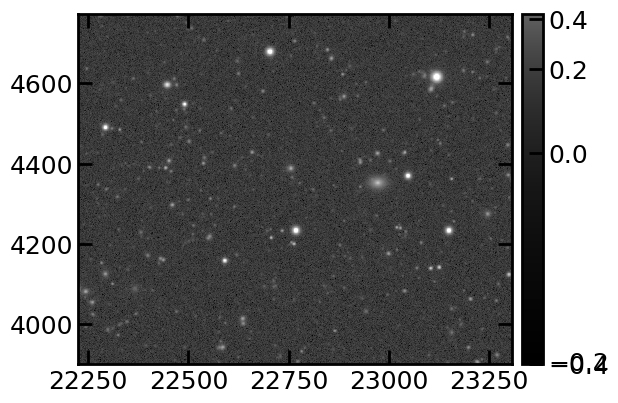

In [16]:
sodaCutout = os.path.join(os.getenv('HOME'), 'DATA/soda-cutout.fits')
with open(sodaCutout, 'bw') as f:
    f.write(sq.execute_stream().read())
    
# Display the cutout
plotImage(ExposureF(sodaCutout))



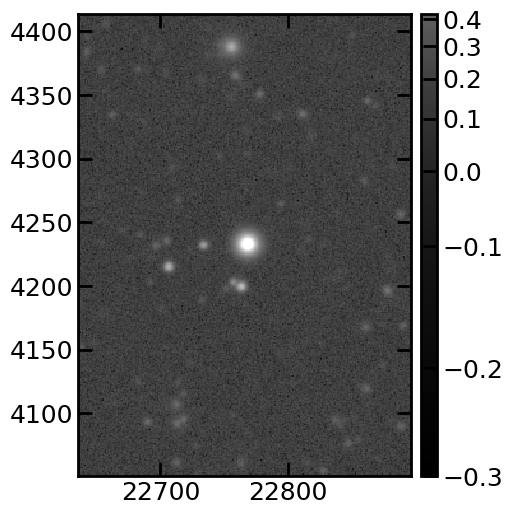

In [17]:
#Alternatively can use polygon to define a region. Actually, circle is easier because there's less to define
#and it looks like "radius" is also half of the box edge. Here's a demonstration using polygon.

#Example: a polygon from (12,34) to (14,34) to (14,36) to (12,36) and (implicitly) back to (12,34):
#POLYGON=12 34 14 34 14 36 12 36
sq2 = SodaQuery.from_resource(dl_results, dl_results.get_adhocservice_by_id("cutout-sync"), 
                             session=auth_session)
sphereRadius2 = 0.01* u.deg

sq2.polygon = (spherePoint.getRa().asDegrees()* u.deg - sphereRadius2,
              spherePoint.getDec().asDegrees()*u.deg - sphereRadius2,
              spherePoint.getRa().asDegrees()* u.deg - sphereRadius2,
              spherePoint.getDec().asDegrees()*u.deg + sphereRadius2,
              spherePoint.getRa().asDegrees()* u.deg + sphereRadius2,
              spherePoint.getDec().asDegrees()*u.deg + sphereRadius2,
              spherePoint.getRa().asDegrees()* u.deg + sphereRadius2,
              spherePoint.getDec().asDegrees()*u.deg - sphereRadius2)


sodaCutout2 = os.path.join(os.getenv('HOME'), 'DATA/soda-cutout.fits')
with open(sodaCutout2, 'bw') as f:
    f.write(sq2.execute_stream().read())
    
# Display the cutout
plotImage(ExposureF(sodaCutout2))


### 2.1 Test out a wrapper function "make_image_cutout" defined above, so we can do all the above operations in one go
IT WORKS :-D

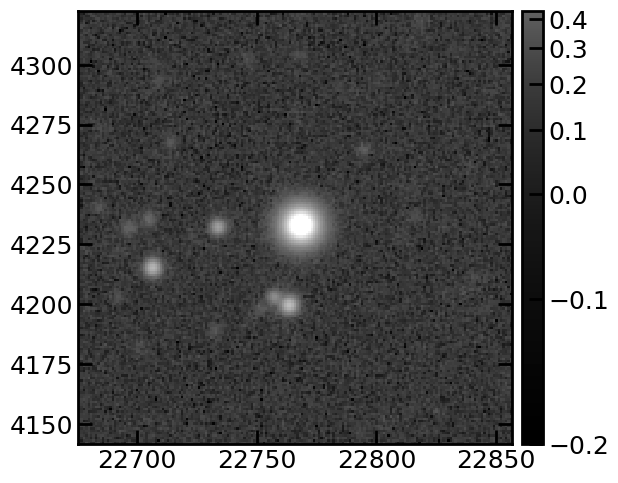

In [18]:
# Test our new function wrapper for the cutout service! IT WORKS :-D

test = make_image_cutout(butler, service, ra, dec, cutout_size=0.005)
plotImage(ExposureF(test))

## 3. Creating cutouts of changing flux for the diaObject

_Use numbers for sections, sub-sections, and sub-sub-sections to enable referencing, e.g., "I'm having trouble with the second code cell in Section 2.3."_

_Use section titles that actively describe what is being done, e.g., "Create a color-magnitude diagram" instead of "Plot", so that the auto-generated table of contents is easy to navigate._

### 3.1 Section Sub-heading

#### 3.1.1 Section Sub-sub-heading

In [20]:
# find the source by matching the source ID, which gives you the exact source
query = "SELECT TOP " + str(100) + " " + \
        "diaObjectId, ra, decl, coord_ra, coord_dec, ccdVisitId " + \
        "FROM dp02_dc2_catalogs.DiaSource " + \
        "WHERE diaObjectId = " + str(diaObjectId) + " "
print(diaObjectId)
visits = service.search(query)
my_tab = visits.to_table()#.to_pandas()
#my_tab['test'] = np.zeros(len(ccdvisit))

# adding cols to pandas tables should be straitforward
# should be able to join the diasource with ccdvisitid tables. join on ccdvisitid 
# adql functionality join will do it. see notebook 02.

1253478440036730088


In [23]:
# ccdvisittable is a separate catalog that contains all observations and I could use that to extract further info. 
# get detector and visit from ccdvisittable using ccdvisitid. 

ccdqu = "SELECT "  + \
        "ccdVisitId, visitId, physical_filter, band, detector, obsStartMJD " + \
        "FROM dp02_dc2_catalogs.CcdVisit " + \
        "WHERE ccdVisitId = " + str(visits['ccdVisitId'][0]) + " "

ccdvisit = service.search(ccdqu)
ccdvisit.to_table().to_pandas()
print(ccdvisit)

my_tab['test'] = np.zeros(len(ccdvisit))

<Table length=1>
ccdVisitId visitId physical_filter  band  detector  obsStartMJD 
  int64     int64       object     object  int64      float64   
---------- ------- --------------- ------ -------- -------------
 427748150  427748       i_sim_1.4      i      150 60192.3985586


In [38]:
# Write a loop to add these values into one table, so that we can then sort by MJD
# visits = DiaObjs
#print(visits, len(visits))
my_tab['MJD'] = np.zeros(len(visits), dtype='float')
#visits.assign(MJD=0).head()
my_tab['visit'] = np.zeros(len(visits), dtype='float')
my_tab['ccdVisitId_test'] = np.zeros(len(visits), dtype='float')
my_tab['detector'] = np.zeros(len(visits), dtype='float')
my_tab['band'] = np.zeros(len(visits), dtype='float')

#dont' forget to check Melissa's test NB about imaging in slack
for j in enumerate(visits['ccdVisitId']):
    #print(j)
    ccdqu = "SELECT "  + \
        "ccdVisitId, visitId, physical_filter, band, detector, obsStartMJD " + \
        "FROM dp02_dc2_catalogs.CcdVisit " + \
        "WHERE ccdVisitId = " + str(j[1]) + " " # AND band = 'r' ?
    ccdvisit = service.search(ccdqu).to_table().to_pandas()
    print(ccdvisit['band'])

    #FSDiaObj['expMidptMJD'][i[0]]=results['expMidptMJD'][0]
    #print(ccdvisit['obsStartMJD'])
    my_tab['MJD'][j[0]] = ccdvisit['obsStartMJD'][0]
    my_tab['visit'][j[0]] = ccdvisit['visitId'][0]
    #my_tab['band'][j[0]] = ccdvisit['band'][0]
    #my_tab['ccdVisitId_test'][j[0]] = ccdvisit['ccdVisitId'][0]
    my_tab['detector'][j[0]] = ccdvisit['detector'][0]
    

    #del ccdvisit


0    i
Name: band, dtype: object
0    z
Name: band, dtype: object
0    z
Name: band, dtype: object
0    r
Name: band, dtype: object
0    r
Name: band, dtype: object
0    r
Name: band, dtype: object
0    r
Name: band, dtype: object
0    r
Name: band, dtype: object
0    r
Name: band, dtype: object
0    i
Name: band, dtype: object
0    i
Name: band, dtype: object
0    i
Name: band, dtype: object
0    i
Name: band, dtype: object
0    i
Name: band, dtype: object
0    i
Name: band, dtype: object
0    g
Name: band, dtype: object
0    g
Name: band, dtype: object
0    g
Name: band, dtype: object


In [25]:
my_tab

diaObjectId,ra,decl,coord_ra,coord_dec,ccdVisitId,test,MJD,visit,ccdVisitId_test,detector
,deg,deg,deg,deg,,,,,,
int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
1253478440036730088,72.5382943,-44.424922,72.5383603,-44.4248533,427748150,0.0,60192.3985586,427748.0,427748150.0,150.0
1253478440036730088,72.5383936,-44.4248675,72.5383603,-44.4248533,243089117,0.0,59915.0918106,243089.0,243089117.0,117.0
1253478440036730088,72.5384084,-44.4248035,72.5383603,-44.4248533,796373054,0.0,60753.0130576,796373.0,796373054.0,54.0
1253478440036730088,72.5385225,-44.424874,72.5383603,-44.4248533,1006105054,0.0,61066.1152046,1006105.0,1006105054.0,54.0
1253478440036730088,72.5383576,-44.4247909,72.5383603,-44.4248533,451597146,0.0,60232.1982036,451597.0,451597146.0,146.0
1253478440036730088,72.5383088,-44.4248487,72.5383603,-44.4248533,1234022160,0.0,61404.2047796,1234022.0,1234022160.0,160.0
1253478440036730088,72.5382676,-44.4248378,72.5383603,-44.4248533,469827037,0.0,60265.1261566,469827.0,469827037.0,37.0
1253478440036730088,72.5383455,-44.4248442,72.5383603,-44.4248533,1195320103,0.0,61331.1689876,1195320.0,1195320103.0,103.0


## questions from Melissa
 how can we show failure modes (i.e. if you make a cutout near the boundary) or max sizes on the cutout?
 maybe that goes in Leanne's notebooK? we should test what happens

get a SN near a host galaxy so looks interesting
real science use cases: lensed SN (short time delay with multiple images) when seeing is bad the sources may be blended, and if seeing is good they are deblended. people will lok for DIAobjects close togehter because they might be the same physical thing. Source association pipeline split into multiple ones in cases like this. Ryan-this has already happened (2 DIAobj close to same position and some images will have some sources and other images will have other sources identified. Now you can plot all the
 cutouts (2-4" of eachother). DP0.2 doesnt' have lensed transients so just pick nearby DIAobjs as a demonstrated failure mode which is a good use case. ask Ryan about this (ticket open to explore source association for DIAobj) users can get seeing out of the catalogs (check schema in DIAsource catalog, measurement of PSF? ccdvisit table has it for the whole visit

 another failure mode using variable stars close together maybe seeing differences between visits get blended but maybe SN science app is better. 

### questions for melissa 4/26:
### - if you want to have a function that uses a butler instance what is the best way to do that?
